In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os

extract_to = '/content'

os.makedirs(extract_to, exist_ok=True)

!tar -xvf "/content/drive/My Drive/Tiny-ImageNet-C.tar" -C {extract_to}


Streaming output truncated to the last 5000 lines.
Tiny-ImageNet-C/zoom_blur/1/n04562935/test_8949.JPEG
Tiny-ImageNet-C/zoom_blur/1/n04562935/test_6394.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_6297.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_5044.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_6615.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_3643.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_286.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_3962.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_5058.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_868.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_6492.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_5311.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_7778.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_8542.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_9007.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_4372.JPEG
Tiny-ImageNet-C/zoom_blur/1/n02950826/test_126.JPEG
Tiny-ImageNe

In [4]:
weights_path = '/content/drive/My Drive/resnet_final.pth'


In [5]:
def load_labels(filename):
    label_map = {}
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            wordnet_id = parts[0]
            label_description = parts[1]
            label_map[wordnet_id] = label_description
    return label_map


label_map = load_labels('words.txt')


In [6]:
def create_label_index_list(folder, label_map):
    wnids = sorted(os.listdir(folder))
    class_names = [label_map[wnid] for wnid in wnids if wnid in label_map]
    return class_names



In [7]:
from PIL import Image
import os

def load_images_with_labels(folders, label_map, label_index_list):
    images = []
    labels = []
    for folder in folders:
        for subdir in os.listdir(folder):
            readable_label = label_map.get(subdir, None)
            if readable_label in label_index_list:
                label_idx = label_index_list.index(readable_label)
                subdir_path = os.path.join(folder, subdir)
                for filename in os.listdir(subdir_path):
                    if filename.endswith('.JPEG'):
                        img_path = os.path.join(subdir_path, filename)
                        img = Image.open(img_path)
                        img.load()
                        images.append(img)
                        labels.append(label_idx)
    return images, labels


In [8]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np

In [105]:
base_path = '/content/Tiny-ImageNet-C/jpeg_compression'
levels = ['5']
folders = [os.path.join(base_path, level) for level in levels]


class_names = create_label_index_list(base_path + '/1', label_map)

images, labels = load_images_with_labels(folders, label_map, class_names)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):

        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label


transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset = CustomDataset(images, labels, transform=transform)

train_size = int(0.8 * len(dataset))
calib_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - calib_size

train_set, calib_set, test_set = random_split(dataset, [train_size, calib_size, test_size])
train_loader = DataLoader(train_set, shuffle=True, batch_size=32)
calib_loader = DataLoader(calib_set, shuffle=False, batch_size=32)
test_loader = DataLoader(test_set, shuffle=False, batch_size=32)

model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).to(device)
model.fc = nn.Linear(in_features=2048, out_features=200)


model.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

In [22]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr=0.00001)
def accuracy_function(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [23]:
from tqdm.auto import tqdm
def train(model, train_loader, loss_fn, optimizer, accuracy_function):
    model.train()
    model.to(device)
    running_loss, running_acc = 0.0, 0.0
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        running_loss += loss.item()
        running_acc += accuracy_function(labels, torch.argmax(outputs, dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return running_loss/len(train_loader), running_acc/len(train_loader)

def validate(model, val_loader, loss_fn, accuracy_function):
  model.eval()
  val_loss, val_acc = 0.0, 0.0
  model.to(device)
  with torch.inference_mode():
    for inputs, labels in tqdm(val_loader):
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)
      val_loss += loss_fn(outputs, labels)
      val_acc += accuracy_function(labels, torch.argmax(outputs, dim=1))
  return val_loss/len(val_loader), val_acc/len(val_loader)

In [107]:
# num_epochs = 3
# for epoch in range(num_epochs):
#     train_loss, train_acc = train(model, train_loader, loss_fn, optimizer, accuracy_function)
#     val_loss, val_acc = validate(model, test_loader, loss_fn, accuracy_function)
#     print(f'epoch: {epoch+1} | Training Loss: {train_loss:.4f} | Training Accuracy: {train_acc:.4f}% | Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}%')


# code for just printing out testing accuracy because the model has already been trained
val_loss, val_acc = validate(model, train_loader, loss_fn, accuracy_function)
print(f'Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}%')

  0%|          | 0/250 [00:00<?, ?it/s]

Val Loss: 2.8663 | Val Accuracy: 40.7125%


In [108]:
model.eval()
model.to(device)
conformal_scores = []

with torch.inference_mode():
  for img, label in calib_loader:
    img, label = img.to(device), label.to(device)
    outputs = model(img)
    softmax_scores = torch.softmax(outputs, dim=1)
    true_softmax = softmax_scores.gather(1, label.unsqueeze(1)).squeeze()
    conformal_scores.append(1-true_softmax)

conformal_scores = torch.cat(conformal_scores)
conformal_scores = conformal_scores.cpu().numpy()

In [109]:
import numpy as np
n = len(calib_set)
alpha = 0.05
q_level = np.ceil((n+1)*(1-alpha)) / n
qhat = np.quantile(conformal_scores, q_level, method='higher')
qhat

0.9996823

In [110]:
import random
#select 1000 indices from the test_data
test_indices = list(range(len(test_set)))
selected_indices = random.sample(test_indices, 1000)
new_samples = torch.utils.data.Subset(test_set, selected_indices)

0it [00:00, ?it/s]

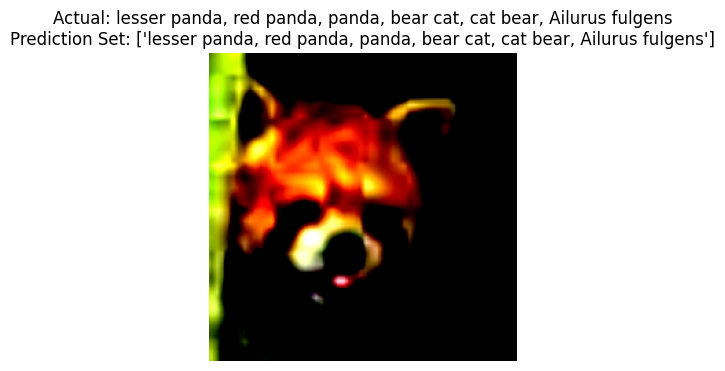

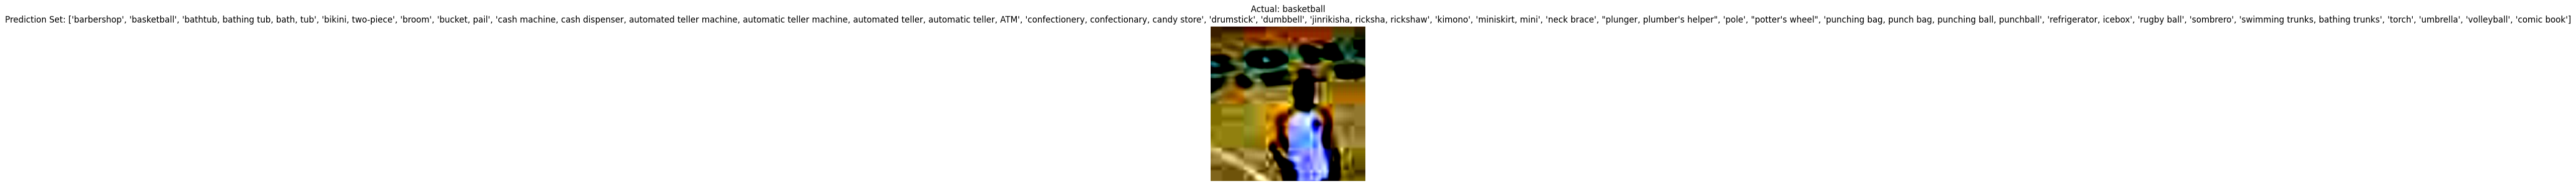

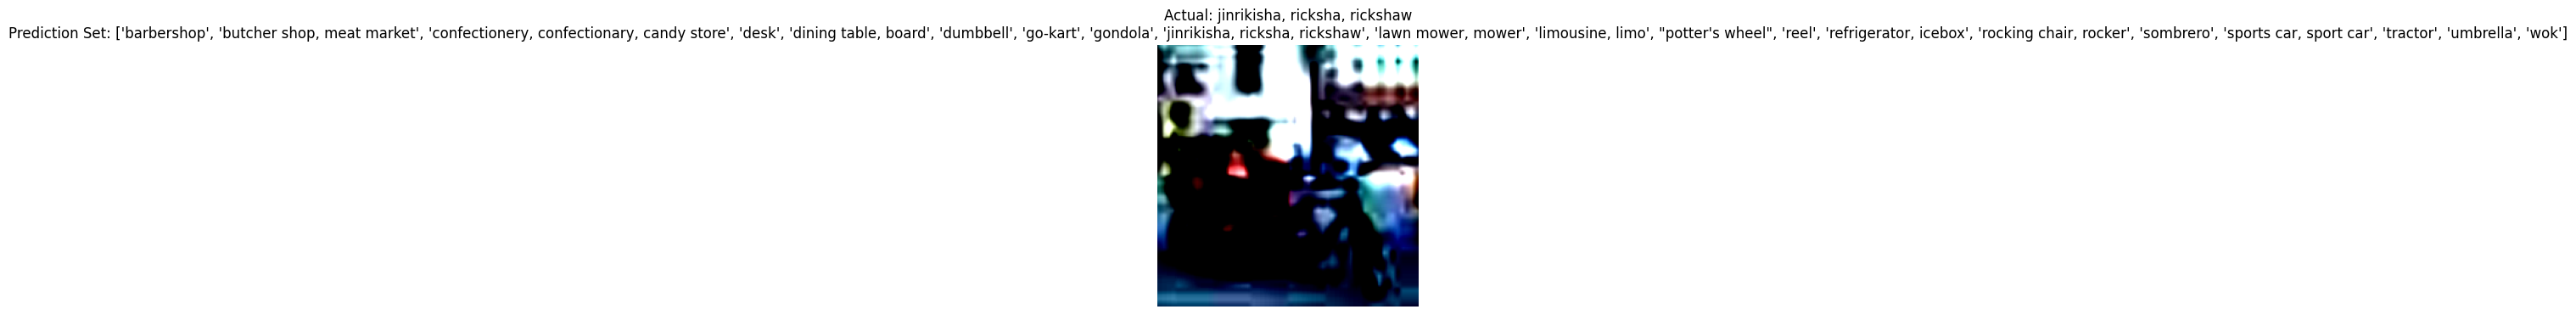

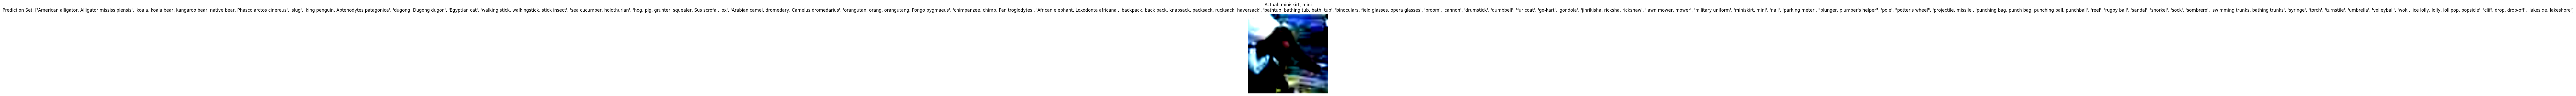

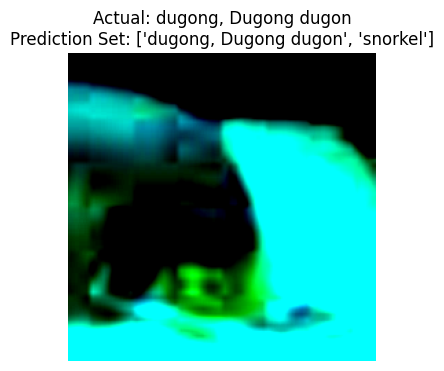

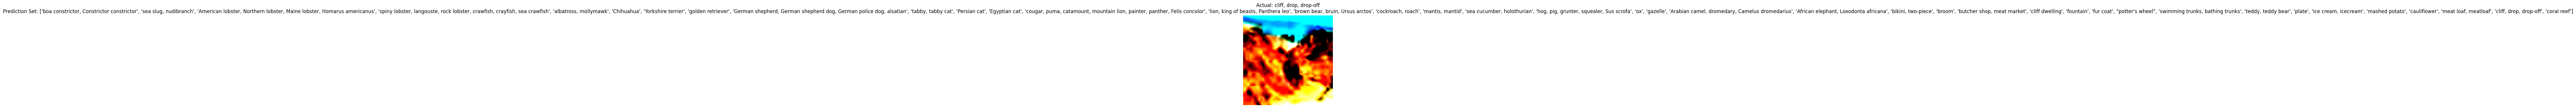

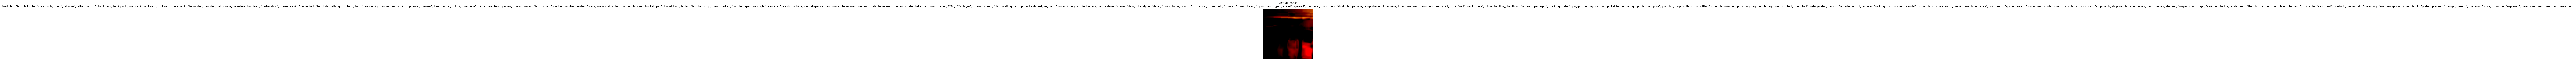

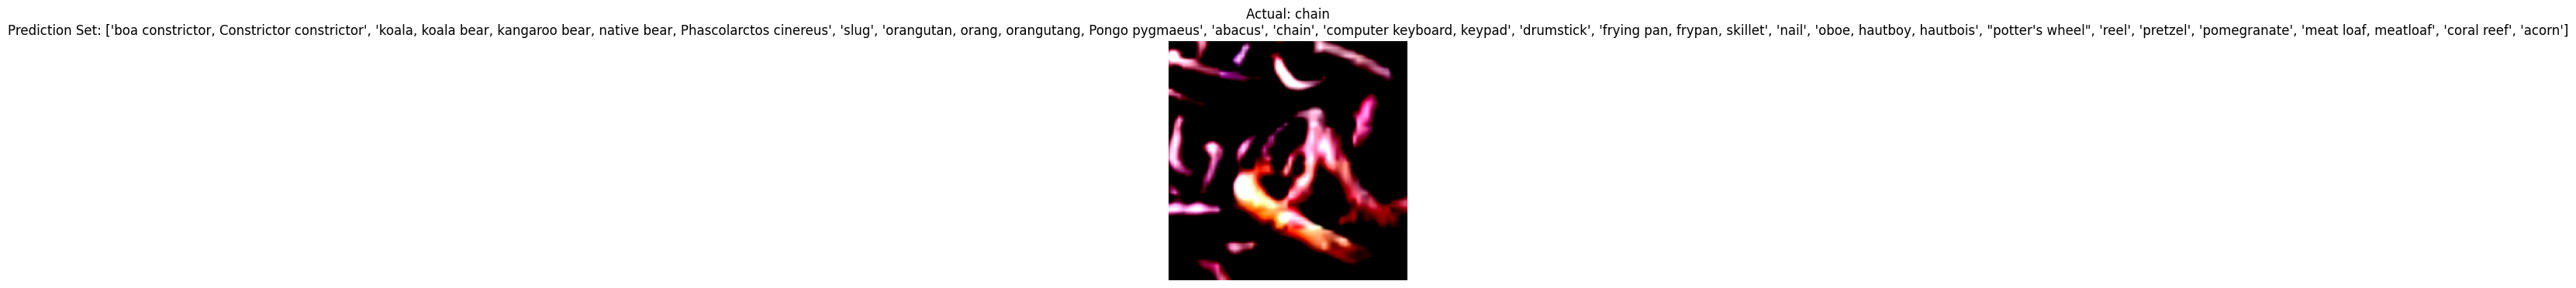

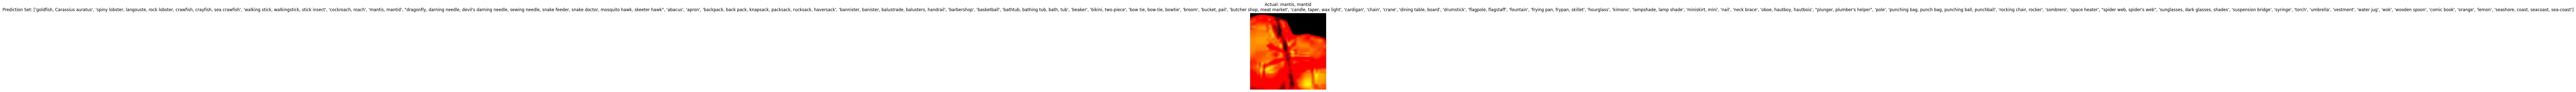

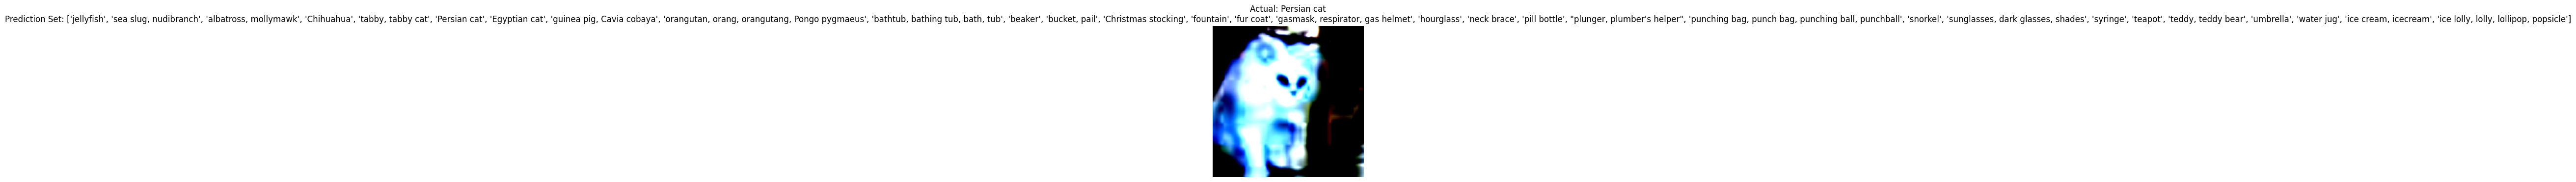

In [111]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
prediction_sets = []
total_length = 0
model.eval()
model = model.to(device)
with torch.inference_mode():
  for i, (img, label) in tqdm(enumerate(new_samples)):
    img = img.to(device)
    outputs = model(img.unsqueeze(dim=0))
    softmax_probs = torch.softmax(outputs, dim=1).squeeze().cpu().numpy()
    prediction_set = np.where(softmax_probs >= (1-qhat))[0]
    prediction_set = [class_names[idx] for idx in prediction_set]
    total_length += len(prediction_set)
    # show prediction set every  100 images
    if i % 100 == 0:
      plt.figure(figsize=(8, 4))
      plt.imshow(img.cpu().permute(1,2,0))
      plt.title(f"Actual: {class_names[label]}\nPrediction Set: {(prediction_set)}")
      plt.axis('off')
      plt.show()

average_length = total_length / len(new_samples)

In [112]:
print(f'Average length of prediction sets: {average_length}')

Average length of prediction sets: 51.094
